# Know Your Skew

Diego Alvarez diego.alvarez@colorado.edu

# Packages

In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Data Prep & EDA

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(parent_dir, "data")

In [3]:
def prep_data(
    file_name: str,
    index_replace: str) -> pd.DataFrame:

    ticker_data_path = os.path.join(data_dir, "{}.csv".format(file_name))
    price_data_path = os.path.join(data_dir, "{}.parquet".format(file_name))

    df_tickers = (pd.read_csv(
        filepath_or_buffer = ticker_data_path).
        query("Category == 'Index/Stats'")
        [["Security", "Description"]].
        assign(Description = lambda x: x.Description.str.replace(index_replace, "")).
        rename(columns = {
            "Security": "security",
            "Description": "description"}))

    df_hf = (pd.read_parquet(
        path  = price_data_path, engine = "pyarrow"))

    df_out = (df_hf.merge(
        right = df_tickers, how = "inner", on = "security"))
    
    return df_out

df_eureka = prep_data("eurekahedge", "Eurekahedge")
df_hfri = prep_data("hfri", "HFRI")
df_hf = pd.concat([df_eureka, df_hfri])

In [4]:
(df_hf[
    ["description", "date"]].
    dropna().
    groupby("description").
    agg(["min", "max", "count"])
    ["date"].
    sort_values("count").
    reset_index())

,description,min,max,count
0,Macro Active Trading Index,2008-12-31,2023-08-31,177
1,Relative Value Fixed Income Sovereign Index,2008-12-31,2023-08-31,177
2,Emerging Markets India Index,2007-12-31,2023-08-31,189
3,Macro Commodity Index,2007-12-31,2023-08-31,189
4,Event Driven Directional Index,2007-12-31,2023-08-31,189
...,...,...,...,...
143,Emerging Markets Hedge Fund Index,2000-01-31,2023-09-30,285
144,North America Event Driven Hedge Fund Index,2000-01-31,2023-09-30,285
145,Emerging Markets Fixed Income Hedge Fund Index,2000-01-31,2023-09-30,285
146,Emerging Markets Multi-Strategy Hedge Fund Index,2000-01-31,2023-09-30,285


# Skew: Basic Statistics

In [5]:
df_skew = (df_hf.pivot(
    index = "date", columns = "security", values = "PX_LAST").
    pct_change().
    reset_index().
    melt(id_vars = "date").
    dropna().
    drop(columns = ["date"]).
    groupby("security").
    agg("skew").
    query("value < 10"))

good_tickers = df_skew.reset_index().security.drop_duplicates().to_list()

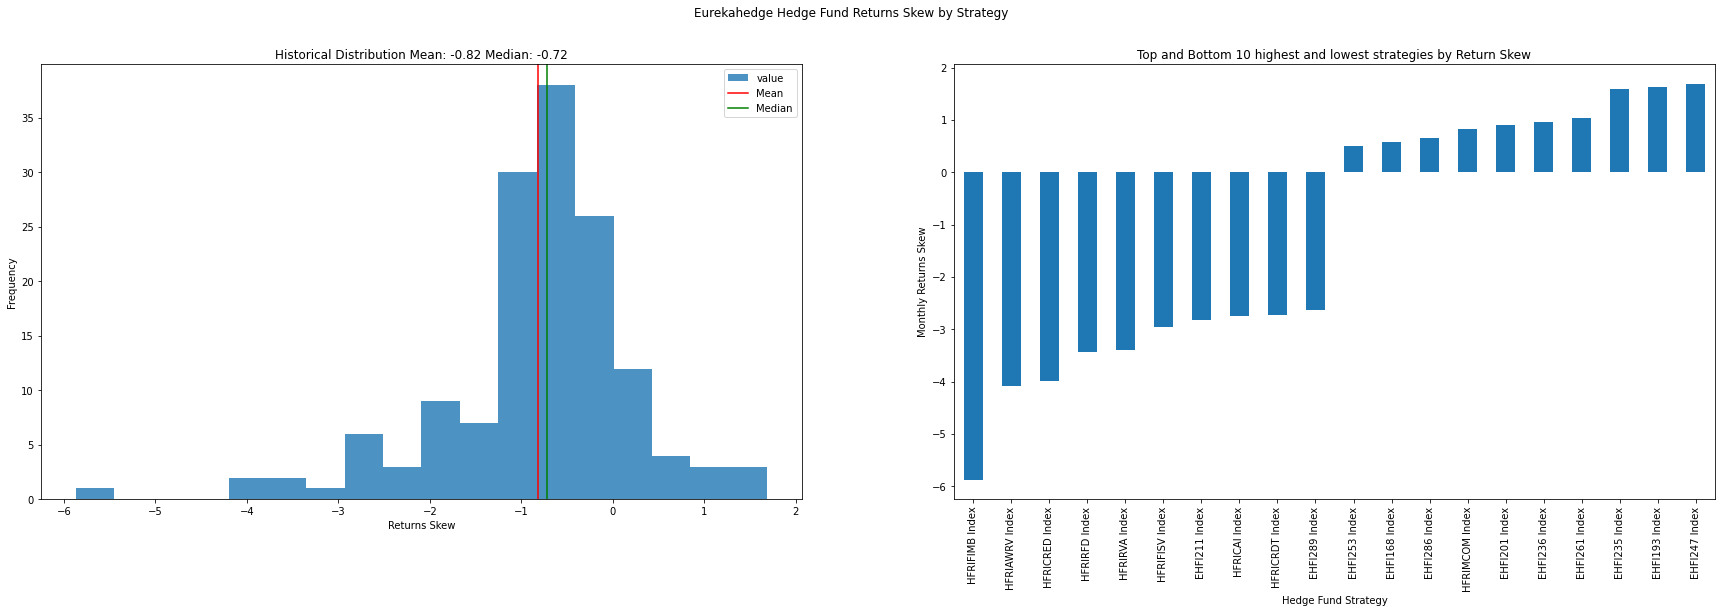

In [6]:
mean = df_skew.mean().iloc[0]
median = df_skew.median().iloc[0]

fig, axes = plt.subplots(ncols = 2, figsize = (30, 8))

(df_skew.plot(
    ax = axes[0],
    kind = "hist",
    bins = 18,
    alpha = 0.8,
    title = "Historical Distribution Mean: {} Median: {}".format(
        round(mean, 2), 
        round(median, 2))))

axes[0].axvline(x = mean, label = "Mean", color = "r")
axes[0].axvline(x = median, label = "Median", color = "g")
axes[0].set_xlabel("Returns Skew")
axes[0].legend()

top_idx = len(df_skew) - 9 #0-indexed
(pd.concat([
    df_skew.sort_values("value").head(10), 
    df_skew.sort_values("value").tail(10)]).
    plot(
        ax = axes[1],
        kind = "bar",
        legend = False,
        title =  "Top and Bottom 10 highest and lowest strategies by Return Skew"))

axes[1].set_xlabel("Hedge Fund Strategy")
axes[1].set_ylabel("Monthly Returns Skew")
fig.suptitle("Eurekahedge Hedge Fund Returns Skew by Strategy")

plt.show()

# Using Skew to esimate maximum loss

In [7]:
def _drawdown(prices: pd.Series) -> float:
    
    prevmaxi = 0
    prevmini = 0
    maxi = 0

    for i in range(len(prices))[1:]:
        if prices[i] >= prices[maxi]:
            maxi = i
            
        else: 
            if (prices[maxi] - prices[i]) > (prices[prevmaxi] - prices[prevmini]):
                prevmaxi = maxi
                prevmini = i
    
    #return (prices[prevmini] / prices[prevmaxi]) - 1
    return prices[prevmini], prices[prevmaxi], prevmini, prevmaxi
    
def drawdown(df: pd.DataFrame) -> pd.DataFrame:
    
    prices = df.sort_values("date").reset_index()["PX_LAST"]
    min_price, max_price, start_index, stop_index = _drawdown(prices)
    sec = df.security.iloc[0]
    
    return(pd.DataFrame({
        "min_price": [min_price],
        "max_price": [max_price],
        "start_date": df["date"].iloc[start_index],
        "end_date": df["date"].iloc[stop_index]}))

In [8]:
df_drawdown = (df_hf.groupby(
    "security").
    apply(drawdown).
    reset_index().
    drop(columns = ["level_1"]).
    assign(drawdown = lambda x:-1 *  ((x.min_price / x.max_price) - 1)).
    sort_values("drawdown"))

In [9]:
df_stats = (df_hf.query(
    "security == @good_tickers").
    pivot(index = "date", columns = "security", values = "PX_LAST").
    pct_change().
    reset_index().
    melt(id_vars = "date").
    drop(columns = ["date"]).
    groupby("security").
    agg(["mean", "skew", "std"])
    ["value"].
    reset_index().
    merge(right = df_drawdown, how = "inner", on = ["security"]).
    assign(
        mean = lambda x: x["mean"],
        norm_drawdown = lambda x: x["drawdown"] / x["std"],
        sharpe = lambda x: x["mean"] / x["std"]).
    query("skew > -5").
    assign(mean = lambda x: x["mean"] * 100))

Calculate all regressions

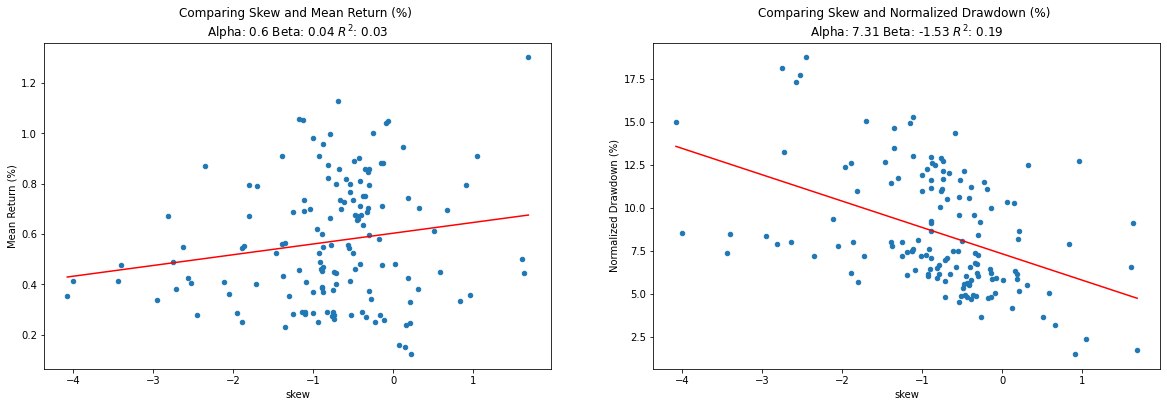

In [10]:
cols = ["mean", "norm_drawdown"]
col_renamer = ["Mean Return (%)", "Normalized Drawdown (%)"]

fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

for i, col in enumerate(cols):
    
    ols = (sm.OLS(
        endog = df_stats[col],
        exog = sm.add_constant(df_stats["skew"])).
        fit())
    
    alpha, beta = ols.params
    rsquared = ols.rsquared
    
    x = np.linspace(start = df_stats["skew"].min(), stop = df_stats["skew"].max(), num = 1_000)
    y = (x * beta) + alpha
    
    (df_stats.plot(
        ax = axes[i],
        kind = "scatter",
        x = "skew", y = col,
        ylabel = col_renamer[i],
        title = "Comparing Skew and {} \nAlpha: {} Beta: {} $R^2$: {}".format(
            col_renamer[i], 
            round(alpha,2),
            round(beta,2),
            round(rsquared,2))))
    
    axes[i].plot(x,y, color = "r")

In [11]:
quantile_drawdown = (df_stats.assign(
    quantiles = lambda x: pd.qcut(x["skew"], 4, ["Q{}".format(i+1) for i in range(4)]))
    [["quantiles", "norm_drawdown"]].
    groupby("quantiles").
    agg("mean"))

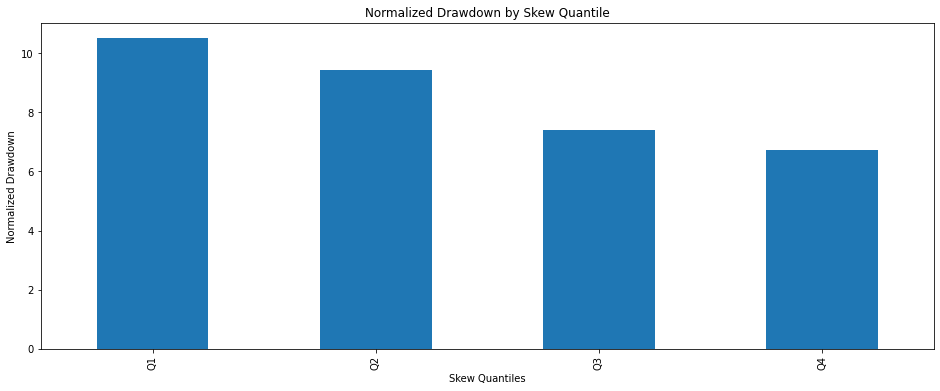

In [12]:
(quantile_drawdown.plot(
    kind = "bar",
    figsize = (16, 6),
    xlabel = "Skew Quantiles",
    ylabel = "Normalized Drawdown",
    legend = False,
    title = "Normalized Drawdown by Skew Quantile"))
plt.show()

# Ex-ante: Estimating maximum loss using skew

In [13]:
def _filter_out(df: pd.DataFrame) -> pd.DataFrame:
    
    df_tmp = (df.query("date < start_date"))
    period = 12 * 5
    if len(df_tmp) > period:
        
        return(df_tmp.sort_values(
            "date").
            assign(
                rtn = lambda x: x.PX_LAST.pct_change(),
                vol = lambda x: x.rtn.rolling(window = period).std() * np.sqrt(12),
                skew = lambda x: x.rtn.rolling(window = period).skew()).
            query("date == date.max()"))
        
    else: 
        print("{} Dropped due to inssufficient data".format(df.description.iloc[0]))

df_preceeding_vol = (df_hf.merge(
    right = df_drawdown, how = "inner", on = ["security"]).
    groupby("security").
    apply(_filter_out).
    reset_index(drop = True).
    assign(norm_drawdown = lambda x: x.drawdown / x.vol))

 Taiwan Long Short Equities Hedge Fund Index Dropped due to inssufficient data
 Asia/Japan Macro Hedge Fund Index Dropped due to inssufficient data
 UCITS Hedge Fund Index Dropped due to inssufficient data
 Index - USD Hedged Dropped due to inssufficient data
 Index - JPY Hedged Dropped due to inssufficient data
 ED Activist Index Dropped due to inssufficient data
 Asset Weighted Composite Index Dropped due to inssufficient data
 Equity Hedge Total Asset Weighted Index Dropped due to inssufficient data
 Asia with Japan Index Dropped due to inssufficient data
 Relative Value Total Asset Weighted Index Dropped due to inssufficient data
 Credit Index Dropped due to inssufficient data
 ED Multi-Strategy Index Dropped due to inssufficient data
 Equity Hedge Fundamental Growth Index Dropped due to inssufficient data
 EH: Long/Short Directional Index Dropped due to inssufficient data
 Emerging Markets India Index Dropped due to inssufficient data
 Macro: Discretionary Directional Index Droppe

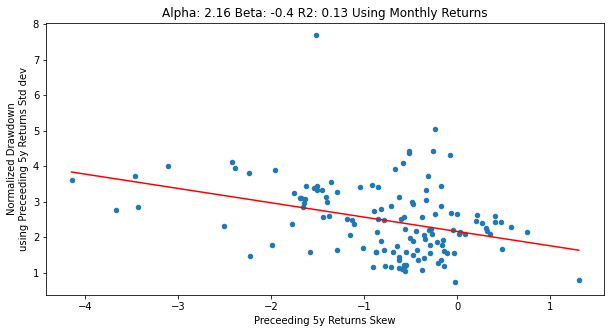

In [14]:
fig, axes = plt.subplots(figsize = (10,5))

regression = (sm.OLS(
    endog = df_preceeding_vol["norm_drawdown"],
    exog = sm.add_constant(df_preceeding_vol["skew"])).
    fit())

alpha, beta = regression.params
rsquared = regression.rsquared

x = np.linspace(
    start = df_preceeding_vol["skew"].min(),
    stop = df_preceeding_vol["skew"].max(),
    num = 1_000)

y = (x * beta) + alpha

(df_preceeding_vol.plot(
    kind = "scatter",
    x = "skew", y = "norm_drawdown",
    xlabel = "Preceeding 5y Returns Skew",
    ylabel = "Normalized Drawdown\nusing Preceeding 5y Returns Std dev",
    ax = axes,
    title = "Alpha: {} Beta: {} R2: {} Using Monthly Returns".format(
        round(alpha, 2),
        round(beta, 2),
        round(rsquared, 2))))

axes.plot(x,y, color = "red")

plt.show()

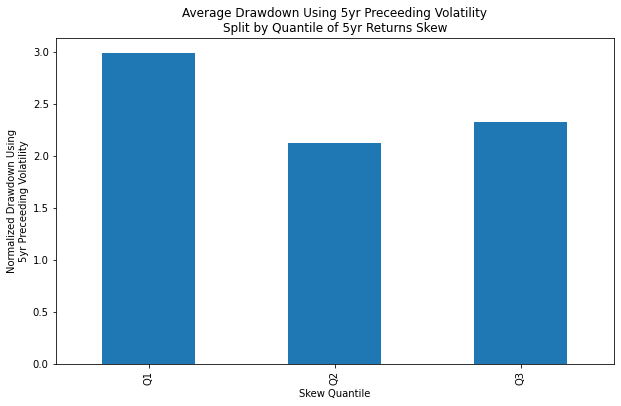

In [15]:
(df_preceeding_vol.assign(
    quantile = lambda x: pd.qcut(x["skew"], 3, ["Q1", "Q2", "Q3"]))
    [["quantile", "norm_drawdown"]].
    groupby("quantile").
    agg("mean").
    plot(
        kind = "bar",
        figsize = (10,6),
        legend = False,
        xlabel = "Skew Quantile",
        ylabel = "Normalized Drawdown Using\n5yr Preceeding Volatility",
        title = "Average Drawdown Using 5yr Preceeding Volatility\nSplit by Quantile of 5yr Returns Skew"))

plt.show()

In [16]:
df_preceeding_split = (df_preceeding_vol.assign(
    skew_sign = lambda x: np.sign(x["skew"])).
    assign(
        quantile_split = lambda x: pd.qcut(x["skew"], 2),
        quantile_name = lambda x: pd.qcut(x["skew"], 2, ["Q1", "Q2"])))

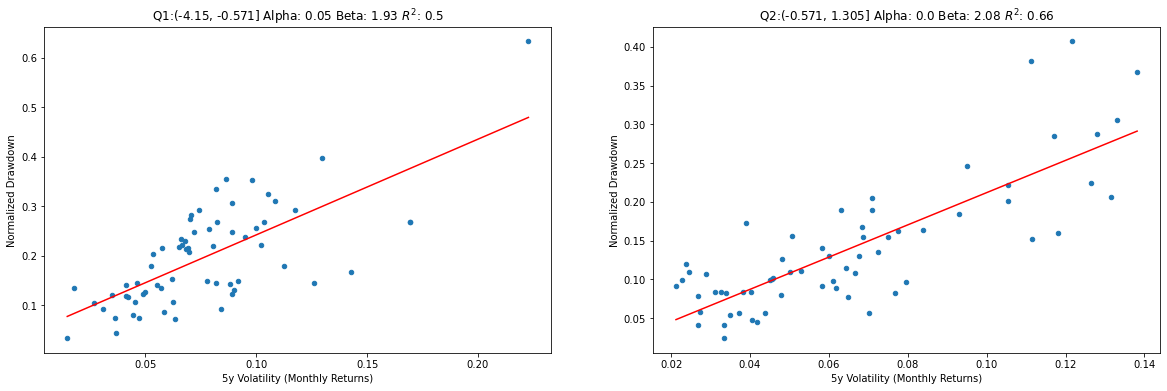

In [17]:
quantile_splits = (df_preceeding_split[
    "quantile_name"].
    drop_duplicates().
    to_list())
fig, axes = plt.subplots(ncols = len(quantile_splits), figsize = (20,6))

for i, quantile_split in enumerate(quantile_splits):

    df_tmp = (df_preceeding_split.query("quantile_name == @quantile_split"))
    
    regression = (sm.OLS(
        endog = df_tmp["drawdown"],
        exog = sm.add_constant(df_tmp["vol"])).
        fit())
    
    alpha, beta = regression.params
    rsquared = regression.rsquared
    
    x = np.linspace(
        start = df_tmp["vol"].min(),
        stop = df_tmp["vol"].max(),
        num = 1_000)
    
    y = (x * beta) + alpha
    
    (df_tmp.plot(
        kind = "scatter", 
        x = "vol", y = "drawdown",
        ax = axes[i],
        ylabel = "Normalized Drawdown",
        xlabel = "5y Volatility (Monthly Returns)",
        title = "{}:{} Alpha: {} Beta: {} $R^2$: {}".format(
            quantile_split,
            df_tmp.quantile_split.iloc[0],
            round(alpha,2),
            round(beta,2),
            round(rsquared,2))))
    
    axes[i].plot(x,y, color = "r")

# Ex-ante: Sharpe Ratio as a predictor of normalized Drawdowns

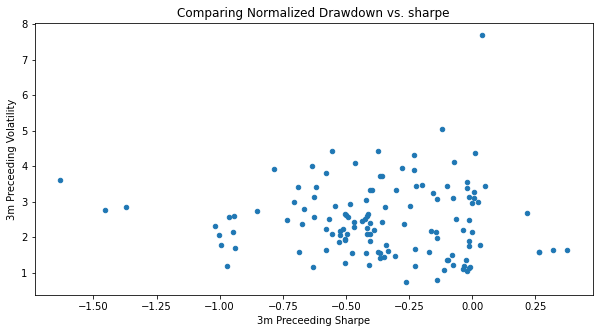

In [18]:
df_preceeding_sharpe = (df_preceeding_split.assign(
    sharpe = lambda x: x.rtn / x.vol))

fig, axes = plt.subplots(figsize = (10,5))

(df_preceeding_sharpe.plot(
    kind = "scatter",
    x = "sharpe", y = "norm_drawdown",
    ylabel = "3m Preceeding Volatility",
    xlabel = "3m Preceeding Sharpe",
    ax = axes,
    title = "Comparing Normalized Drawdown vs. sharpe"))

plt.show()

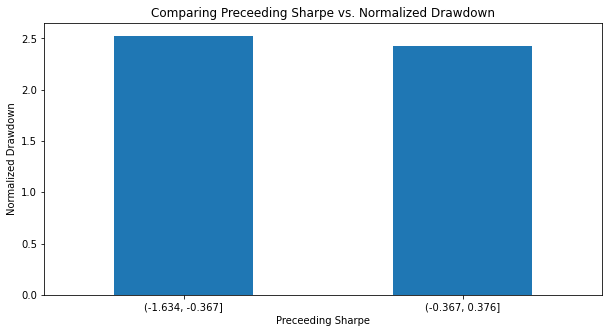

In [19]:
(df_preceeding_sharpe.assign(
    quantile_name = lambda x: pd.qcut(x["sharpe"], 2))
    [["norm_drawdown", "quantile_name"]].
    groupby("quantile_name").
    agg("mean").
    plot(
        kind = "bar",
        figsize = (10,5),
        rot = 0,
        legend = False,
        xlabel = "Preceeding Sharpe",
        ylabel = "Normalized Drawdown",
        title = "Comparing Preceeding Sharpe vs. Normalized Drawdown"))

plt.show()

In [20]:
def _get_max(df: pd.DataFrame) -> pd.DataFrame:
    return(df.query("date == date.max()"))

period = 12

norm_vol_range = (df_hf.drop(
    columns = "description").
    pivot(index = "date", columns = "security", values = "PX_LAST").
    pct_change().
    reset_index().
    melt(id_vars = "date", value_name = "rtn").
    dropna().
    assign(
        rolling_std = lambda x: x.rtn.rolling(window = period).std() * np.sqrt(period),
        vol_range = lambda x: x.rolling_std.rolling(window = period).max() - x.rolling_std.rolling(window = period).min(),
        norm_vol_range = lambda x: x.vol_range / x.rolling_std.rolling(window = period).std().mean()).
    groupby("security").
    apply(_get_max).
    reset_index(drop = True)
    [["security", "norm_vol_range"]])

In [21]:
df_vol_range = (df_hf.drop(
    columns = ["description"]).
    pivot(index = "date", columns = "security", values = "PX_LAST").
    pct_change().
    reset_index().
    melt(id_vars = "date").
    dropna().
    drop(columns = ["date"]).
    groupby("security").
    agg("skew").
    reset_index().
    merge(right = norm_vol_range, how = "inner", on = ["security"]).
    rename(columns = {"value": "skew"}).
    query("skew < 15 & norm_vol_range < 3"))

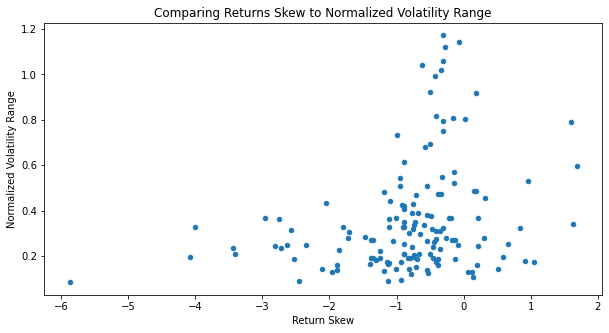

In [22]:
df_vol_range.plot(
    kind = "scatter",
    x = "skew",
    y = "norm_vol_range",
    xlabel = "Return Skew",
    ylabel = "Normalized Volatility Range",
    title = "Comparing Returns Skew to Normalized Volatility Range",
    figsize = (10,5))

plt.show()

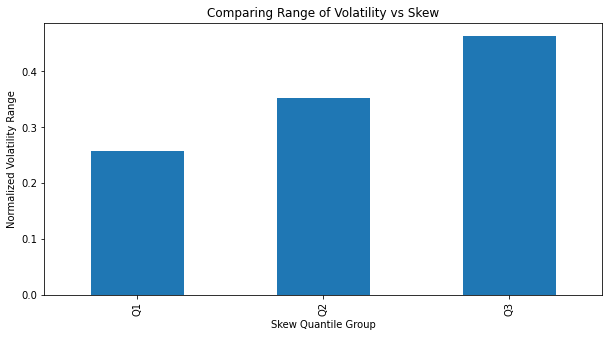

In [23]:
(df_vol_range.assign(
    quantile = lambda x: pd.qcut(x["skew"], 3, ["Q1", "Q2", "Q3"]))
    [["quantile", "norm_vol_range"]].
    groupby("quantile").
    agg("mean").
    plot(
        kind = "bar",
        ylabel = "Normalized Volatility Range",
        xlabel = "Skew Quantile Group",
        legend = False,
        title = "Comparing Range of Volatility vs Skew",
        figsize = (10,5)))

plt.show()

# Correlation to S&P 500 and skew

In [24]:
start_date, end_date = df_hf.date.min().date(), df_hf.date.max().date()
df_yf = yf.download(tickers = "^SPX", start = start_date, end = end_date)

[*********************100%***********************]  1 of 1 completed


In [25]:
df_hf

,date,security,PX_LAST,description
0,2000-01-31,EHFI255 Index,100.9709,Relative Value Hedge Fund Index
1,2000-02-29,EHFI255 Index,104.0071,Relative Value Hedge Fund Index
2,2000-03-31,EHFI255 Index,107.6319,Relative Value Hedge Fund Index
3,2000-04-30,EHFI255 Index,107.8118,Relative Value Hedge Fund Index
4,2000-05-31,EHFI255 Index,108.8080,Relative Value Hedge Fund Index
...,...,...,...,...
15981,2023-04-30,HFRIMACT Index,1573.1010,Macro Active Trading Index
15982,2023-05-31,HFRIMACT Index,1565.1430,Macro Active Trading Index
15983,2023-06-30,HFRIMACT Index,1588.6490,Macro Active Trading Index
15984,2023-07-31,HFRIMACT Index,1601.8530,Macro Active Trading Index


In [26]:
df_spx = (df_hf.drop(
    columns = ["description"]).
    pivot(index = "date", columns = "security", values = "PX_LAST").
    reset_index().
    merge(
        right = df_yf.reset_index().rename(columns = {"Date": "date"})[["Adj Close", "date"]], 
        how = "inner", 
        on = "date").
    set_index("date").
    pct_change().
    reset_index().
    rename(columns = {"Adj Close": "SPX"}).
    melt(id_vars = "date"))

df_corr = (df_spx.query(
    "variable != 'SPX'").
    merge(
        right = df_spx.query("variable == 'SPX'").drop(columns = ["variable"]).rename(columns = {"value": "SPX"}),
        how = "inner",
        on = ["date"]).
    dropna().
    drop(columns = ["date"]).
    groupby("variable").
    agg("corr")
    [["SPX"]].
    reset_index().
    query("level_1 == 'value'").
    drop(columns = ["level_1"]))

tickers = df_corr.variable.drop_duplicates().to_list()

In [27]:
df_skew = (df_hf.query(
    "security == @tickers").
    drop(columns = ["description"]).
    pivot(index = "date", columns = "security", values = "PX_LAST").
    pct_change().
    reset_index().
    melt(id_vars = "date").
    dropna().
    drop(columns = ["date"]).
    groupby("security").
    agg("skew").
    rename(columns = {"value": "skew"}))

In [28]:
df_spx_skew = (df_corr.merge(
    right = df_skew.reset_index().rename(columns = {"security": "variable"}),
    how = "inner",
    on = ["variable"]).
    query("skew < 15"))

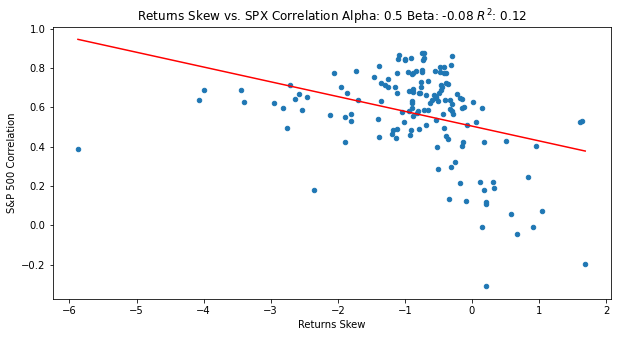

In [29]:
fig, axes = plt.subplots(figsize = (10,5))

regression = (sm.OLS(
    endog = df_spx_skew["SPX"],
    exog = sm.add_constant(df_spx_skew["skew"])).
    fit())

alpha, beta = regression.params
rsquared = regression.rsquared

x = np.linspace(
    start = df_spx_skew["skew"].min(),
    stop = df_spx_skew["skew"].max(),
    num = 1_000)

y = (x * beta) + alpha

(df_spx_skew.plot(
    kind = "scatter",
    x = "skew", y = "SPX",
    ax = axes,
    ylabel = "S&P 500 Correlation",
    xlabel = "Returns Skew",
    title = "Returns Skew vs. SPX Correlation Alpha: {} Beta: {} $R^2$: {}".format(
        round(alpha,2),
        round(beta,2),
        round(rsquared,2))))

axes.plot(x,y, color = "r")
plt.show()

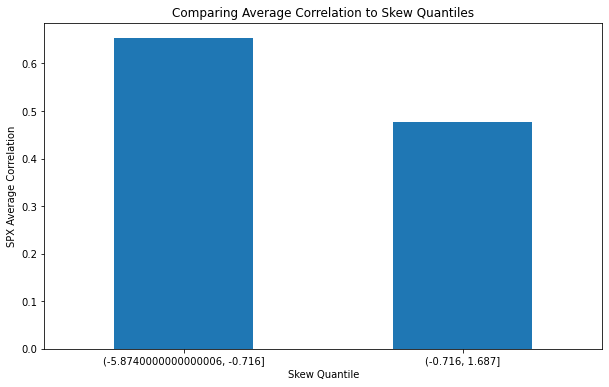

In [30]:
(df_spx_skew.assign(
    quantile = lambda x: pd.qcut(x["skew"], 2)).
    drop(columns = ["skew", "variable"]).
    groupby("quantile").
    agg("mean").
    plot(
        kind = "bar",
        rot = 0,
        figsize = (10,6),
        ylabel = "SPX Average Correlation",
        xlabel = "Skew Quantile",
        title = "Comparing Average Correlation to Skew Quantiles",
        legend = False))

plt.show()